In [1]:
! export JAX_PLATFORMS=cpu

# Hyperfine solutions and spin-density for H2S

Compute the hyperfine energies and wavefunctions for selected rotational cluster states of $\text{H}_2\text{S}$.
The hyperfine interaction is represented by the spin-rotation coupling.

Compute the nuclear-spin densities (rotational distribution of nuclear spins) to determine if the ortho-para interaction can induce the nuclear spin polarisation.

In [43]:
import h5py
import hdfdict
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from rovib.spinrot_xy2 import spinrot_xy2
from scipy import constants
from scipy.sparse import csr_matrix

config.update("jax_enable_x64", True)
KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

Start by reading the indices of rotational cluster states for different $J$ quanta, sored in file `h2s_cluster_states.txt`. These states were identified in `h2s_clusters.ipynb`.

In [45]:
print("Rotational cluster states")

cluster_state_id = {}

with open("h2s_cluster_states_id.txt", "r") as fl:
    for line in fl:
        w = line.split()
        j = [int(w[0 + i * 12]) for i in range(4)]
        id = [int(w[1 + i * 12]) for i in range(4)]
        sym = [w[3 + i * 12] for i in range(4)]
        assert all(j[0] == elem for elem in j), f"Not all J quanta are equal: {j}"
        j_ = j[0]

        if j_ >= 50:
            cluster_state_id[j_] = {}
            for sym_, id_ in zip(sym, id):
                try:
                    cluster_state_id[j_][sym_].append(id_)
                except KeyError:
                    cluster_state_id[j_][sym_] = [id_]
            print(f"J = {j_}, cluster-state IDs: {cluster_state_id[j_]}")

Rotational cluster states
J = 50, cluster-state IDs: {'B2': [277], 'A2': [242], 'B1': [242], 'A1': [280]}
J = 51, cluster-state IDs: {'A1': [267], 'B1': [299], 'B2': [270], 'A2': [299]}
J = 52, cluster-state IDs: {'B2': [324], 'A2': [291], 'A1': [327], 'B1': [291]}
J = 53, cluster-state IDs: {'A1': [316], 'B1': [354], 'B2': [318], 'A2': [353]}
J = 54, cluster-state IDs: {'B2': [385], 'A2': [345], 'A1': [387], 'B1': [344]}
J = 55, cluster-state IDs: {'A1': [371], 'B1': [413], 'A2': [412], 'B2': [373]}
J = 56, cluster-state IDs: {'B2': [447], 'A2': [399], 'B1': [399], 'A1': [450]}
J = 57, cluster-state IDs: {'A1': [432], 'B1': [487], 'B2': [434], 'A2': [486]}
J = 58, cluster-state IDs: {'B2': [520], 'B1': [468], 'A1': [523], 'A2': [469]}
J = 59, cluster-state IDs: {'A1': [503], 'B1': [565], 'A2': [563], 'B2': [505]}
J = 60, cluster-state IDs: {'B1': [542], 'A1': [600], 'A2': [544], 'B2': [599]}


Load the rovibrational energies and matrix elements of spin-rotation tensors, computed and sotred in `h2s_cart_me.ipynb`.

In [50]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_spinrot_enr_pmax{pmax}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)

enr = {
    int(J): {sym: enr_sym for sym, enr_sym in enr_J.items()} for J, enr_J in enr.items()
}

qua = {
    int(J): {
        sym: np.array([elem[0].decode("utf-8").split(",") for elem in qua_sym])
        for sym, qua_sym in qua_J.items()
    }
    for J, qua_J in qua.items()
}

for J in enr.keys():
    for sym in enr[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr[J][sym].shape}, qua.shape = {qua[J][sym].shape}"
        )

print(f"Read spin-rotation marix elements for J = {min_J}..{max_J}")

sr1 = {}
sr2 = {}

for J1 in range(min_J, max_J + 1):
    for J2 in range(min_J, max_J + 1):
        try:
            filename = f"h2s_spinrot_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1_ = hdfdict.load(h5.require_group("h1"), False)
                sr2_ = hdfdict.load(h5.require_group("h2"), False)
                sr1[(J1, J2)] = {
                    (sym1, sym2): csr_matrix(
                        (me["data"], me["indices"], me["indptr"]),
                        shape=me["shape"],
                    )
                    .toarray()
                    .reshape(len(enr[J1][sym1]), len(enr[J2][sym2]), -1)
                    for sym1, me_sym1 in sr1_.items()
                    for sym2, me in me_sym1.items()
                }
                sr2[(J1, J2)] = {
                    (sym1, sym2): csr_matrix(
                        (me["data"], me["indices"], me["indptr"]),
                        shape=me["shape"],
                    )
                    .toarray()
                    .reshape(len(enr[J1][sym1]), len(enr[J2][sym2]), -1)
                    for sym1, me_sym1 in sr2_.items()
                    for sym2, me in me_sym1.items()
                }
        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = A1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 50, sym = A2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 50, sym = B1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 50, sym = B2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 51, sym = A1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 51, sym = A2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 51, sym = B1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 51, sym = B2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 52, sym = A1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 52, sym = A2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 52, sym = B1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 52, sym = B2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 53, sym = A1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 53, sym = A2, enr.shape = (1000,), qua.shape = (1000, 9)
J = 53, sym = B1, enr.shape = (1000,), qua.shape = (1000, 9)
J = 53, sym = B2, enr.shape = (100

Compute hyperfine energies and wavefunctions, identify hyperfine states that belong to the cluster states.

In [68]:
min_F = 50
max_F = 60

hyper_enr = {}
hyper_vec = {}
hyper_qua = {}
hyper_shift = {}
hyper_id = {}
hyper_rov_sym = {}

print(f"Compute hyperfine states for F = {min_F}..{max_F}")

for F in range(min_F, max_F + 1):

    # comupute hyperfine spin-rotation energies and wavefunctions

    hyper_enr[F], hyper_vec[F], hyper_qua[F] = spinrot_xy2(
        F, enr, qua, sr1, sr2, spin_states=((0, "B2"), (1, "A1")), spins=(0.5, 0.5)
    )

    # select hyperfine cluster states based on the largest
    # leading contribution from one of the cluster states

    hyper_id[F] = {}
    for sym in hyper_enr[F].keys():
        ind = np.argmax(hyper_vec[F][sym] ** 2, axis=0)
        id = [
            list(
                np.where(
                    (hyper_qua[F][sym][ind, 0].astype(int) == rov_ind[0])
                    & (hyper_qua[F][sym][ind, 1] == rov_sym)
                    & (hyper_qua[F][sym][ind, 2].astype(int) == int(F))
                )[0]
            )
            for rov_sym, rov_ind in cluster_state_id[int(F)].items()
        ]  # indices of hyperfine states with leading contribution from cluster states
        hyper_id[F][sym] = sum(id, [])

    # print assignments of hypefine cluster states

    hyper_shift[F] = {sym: [] for sym in hyper_id[F].keys()}
    hyper_rov_sym[F] = {sym: [] for sym in hyper_id[F].keys()}
    for sym in hyper_id[F].keys():
        for i in hyper_id[F][sym]:
            ind = np.argmax(hyper_vec[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua[F][sym][ind][0])
            rov_sym = hyper_qua[F][sym][ind][1]
            j = int(hyper_qua[F][sym][ind][2])
            rov_enr = enr[j][rov_sym][rov_ind]
            hyper_shift[F][sym].append((hyper_enr[F][sym][i] - rov_enr) / KHZ_TO_INVCM)
            hyper_rov_sym[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr[F][sym][i]}, shift (kHz) = {hyper_shift[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua[F][sym][ind]}, max(c**2) = {hyper_vec[F][sym][ind, i]**2}"
            )

Compute hyperfine states for F = 50..60
F = 50, sym = B1, enr = 24708.81878741134, shift (kHz) = -251.31552741805572, leading quanta = ['242' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2' '0' 'B2'], max(c**2) = (0.9304308871320092-0j)
F = 50, sym = B1, enr = 24708.818907908753, shift (kHz) = 235.5133736800286, leading quanta = ['242' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1' '1' 'A1'], max(c**2) = (0.930430887132007+0j)
F = 50, sym = B2, enr = 24708.818786957, shift (kHz) = -264.91317333625705, leading quanta = ['277' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1' '1' 'A1'], max(c**2) = (0.931559792337291-0j)
F = 50, sym = B2, enr = 24708.81890837051, shift (kHz) = 249.11243742842126, leading quanta = ['280' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2' '0' 'B2'], max(c**2) = (0.9315597923372968+0j)
F = 51, sym = B1, enr = 25447.364236702033, shift (kHz) = -329.44004317473735, leading quanta = ['299' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1' '1' 'A1'], max(c**2) = (0.8995883619918892+0j)
F = 51, sym = B

Plot absolute values of hyperfine shifts for all cluster states as function of quantum number of total angular momentum $F$.

When examining the square of the coefficient for the leading basis function, it remains close to 0.9 for $J=50..54$.
In this range, the plot shows that the hyperfine shift for different symmetries alternates sign between even and odd $J$ values.
However, for $J\geq 55$, this behavior is not evident in the plots.
This is because the square of the coefficient for the leading function approaches $1/\sqrt{2}$ leading
to an ambiguous assignment of states based on rovibrational symmetry, as severalka states become strongly coupled.

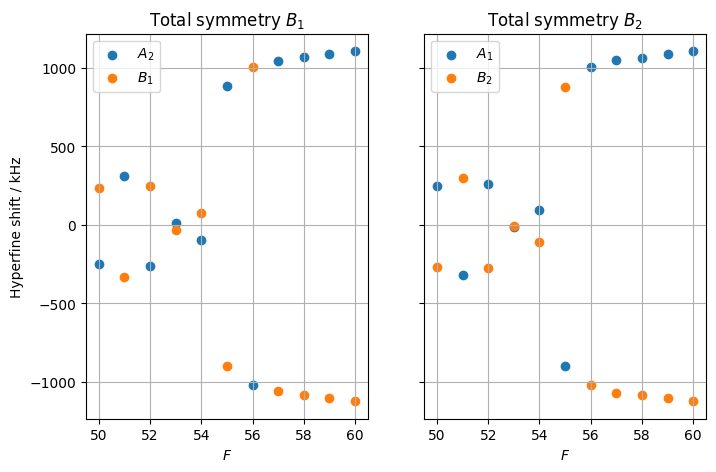

In [117]:
F_list = list(hyper_shift.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B1"], [])
        for F in hyper_shift.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift[F].items() if sym == "B2"], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()

We can also try to compute hyperfine energies and wavefunctions including only cluster states into the basis and neglect the coupling of states with $|\Delta J|>0$.
The results in the printout of hyperfine states and the plot of hyperfine shifts are numerically similar to those above, which were obtained considering all states.

In [120]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_spinrot_enr_pmax{pmax}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)

enr_cluster = {
    J: {sym: enr[str(J)][sym][id] for sym, id in id_J.items()}
    for J, id_J in cluster_state_id.items()
}

qua_cluster = {
    J: {
        sym: np.array(
            [elem[0].decode("utf-8").split(",") for elem in qua[str(J)][sym][id]]
        )
        for sym, id in id_J.items()
    }
    for J, id_J in cluster_state_id.items()
}

for J in enr_cluster.keys():
    for sym in enr_cluster[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr_cluster[J][sym].shape}, "
            + f"qua.shape = {qua_cluster[J][sym].shape}"
        )

print(f"Read spin-rotation marix elements for J = {min_J}..{max_J}")

sr1_cluster = {}
sr2_cluster = {}

for J1, id_J1 in cluster_state_id.items():
    for J2, id_J2 in cluster_state_id.items():
        try:
            filename = f"h2s_spinrot_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("h1"), False)
                sr2 = hdfdict.load(h5.require_group("h2"), False)

                sr_sym = [{}, {}]
                for sym1, id1 in id_J1.items():
                    for sym2, id2 in id_J2.items():
                        nstates1 = len(enr[str(J1)][sym1])
                        nstates2 = len(enr[str(J2)][sym2])
                        for i, sr in enumerate((sr1, sr2)):
                            if sym1 in sr and sym2 in sr[sym1]:
                                me = sr[sym1][sym2]
                                sr_sym[i][(sym1, sym2)] = (
                                    csr_matrix(
                                        (me["data"], me["indices"], me["indptr"]),
                                        shape=me["shape"],
                                    )
                                    .toarray()
                                    .reshape(nstates1, nstates2, -1)[np.ix_(id1, id2)]
                                )
                sr1_cluster[(J1, J2)] = sr_sym[0]
                sr2_cluster[(J1, J2)] = sr_sym[1]
        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = B2, enr.shape = (1,), qua.shape = (1, 9)
J = 50, sym = A2, enr.shape = (1,), qua.shape = (1, 9)
J = 50, sym = B1, enr.shape = (1,), qua.shape = (1, 9)
J = 50, sym = A1, enr.shape = (1,), qua.shape = (1, 9)
J = 51, sym = A1, enr.shape = (1,), qua.shape = (1, 9)
J = 51, sym = B1, enr.shape = (1,), qua.shape = (1, 9)
J = 51, sym = B2, enr.shape = (1,), qua.shape = (1, 9)
J = 51, sym = A2, enr.shape = (1,), qua.shape = (1, 9)
J = 52, sym = B2, enr.shape = (1,), qua.shape = (1, 9)
J = 52, sym = A2, enr.shape = (1,), qua.shape = (1, 9)
J = 52, sym = A1, enr.shape = (1,), qua.shape = (1, 9)
J = 52, sym = B1, enr.shape = (1,), qua.shape = (1, 9)
J = 53, sym = A1, enr.shape = (1,), qua.shape = (1, 9)
J = 53, sym = B1, enr.shape = (1,), qua.shape = (1, 9)
J = 53, sym = B2, enr.shape = (1,), qua.shape = (1, 9)
J = 53, sym = A2, enr.shape = (1,), qua.shape = (1, 9)
J = 54, sym = B2, enr.shape = (1,), qua.shape = (1, 9)
J = 54, sym = 

In [122]:
min_F = 50
max_F = 60

hyper_enr_cluster = {}
hyper_vec_cluster = {}
hyper_qua_cluster = {}
hyper_shift_cluster = {}
hyper_rov_sym_cluster = {}

for F in range(min_F, max_F + 1):

    J = F

    # comupute hyperfine spin-rotation energies and wavefunctions

    hyper_enr_cluster[F], hyper_vec_cluster[F], hyper_qua_cluster[F] = spinrot_xy2(
        F,
        {J: enr_cluster[J]},
        {J: qua_cluster[J]},
        {(J, J): sr1_cluster[(J, J)]},
        {(J, J): sr2_cluster[(J, J)]},
        spin_states=((0, "B2"), (1, "A1")),
        spins=(0.5, 0.5),
    )

    # print assignments of hypefine cluster states

    hyper_shift_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    hyper_rov_sym_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    for sym in hyper_enr_cluster[F].keys():
        for i in range(len(hyper_enr_cluster[F][sym])):
            ind = np.argmax(hyper_vec_cluster[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua_cluster[F][sym][ind][0])
            rov_sym = hyper_qua_cluster[F][sym][ind][1]
            j = int(hyper_qua_cluster[F][sym][ind][2])
            rov_enr = enr_cluster[j][rov_sym][rov_ind]
            hyper_shift_cluster[F][sym].append(
                (hyper_enr_cluster[F][sym][i] - rov_enr) / KHZ_TO_INVCM
            )
            hyper_rov_sym_cluster[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr_cluster[F][sym][i]}, shift (kHz) = {hyper_shift_cluster[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua_cluster[F][sym][ind]}, max(c**2) = {hyper_vec_cluster[F][sym][ind, i]**2}"
            )

F = 50, sym = B1, enr = 24708.81878741142, shift (kHz) = -251.3131280131165, leading quanta = ['0' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2' '0' 'B2'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B1, enr = 24708.81890790879, shift (kHz) = 235.51446431863732, leading quanta = ['0' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1' '1' 'A1'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B2, enr = 24708.818786957007, shift (kHz) = -264.91295520853527, leading quanta = ['0' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1' '1' 'A1'], max(c**2) = (0.9315598651704518-0j)
F = 50, sym = B2, enr = 24708.818908370573, shift (kHz) = 249.1142915140561, leading quanta = ['0' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2' '0' 'B2'], max(c**2) = (0.9315598651704518+0j)
F = 51, sym = B1, enr = 25447.364236702117, shift (kHz) = -329.4375347059373, leading quanta = ['0' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1' '1' 'A1'], max(c**2) = (0.8995880069142649-0j)
F = 51, sym = B1, enr = 25447.3643408951, shift (kHz) = 313.6495

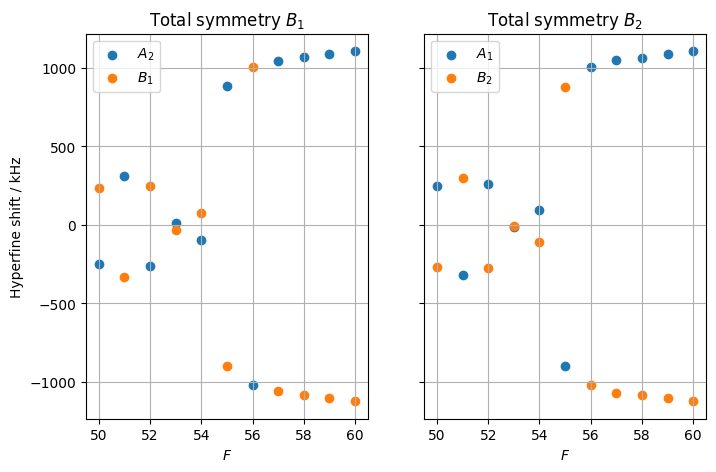

In [124]:
F_list = list(hyper_shift_cluster.keys())

shift_B1 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B1"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

shift_B2 = np.array(
    [
        sum([val for sym, val in hyper_shift_cluster[F].items() if sym == "B2"], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B1 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A2", "B1")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

rov_sym_B2 = np.array(
    [
        sum([val for sym, val in hyper_rov_sym_cluster[F].items() if sym in ("A1", "B2")], [])
        for F in hyper_shift_cluster.keys()
    ]
)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 5))

for sym in ("A2", "B1"):
    ind = [np.where(rov_sym_B1[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B1[i, j] for i, j in enumerate(ind)]
    ax[0].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

for sym in ("A1", "B2"):
    ind = [np.where(rov_sym_B2[i] == sym)[0] for i in range(len(F_list))]
    sh = [shift_B2[i, j] for i, j in enumerate(ind)]
    ax[1].scatter(F_list, sh, label=f"${sym[0]}_{sym[1]}$")

ax[0].set_title("Total symmetry $B_1$")
ax[0].set_xlabel("$F$")
ax[0].set_ylabel("Hyperfine shift / kHz")
ax[0].grid()
ax[0].legend()

ax[1].set_title("Total symmetry $B_2$")
ax[1].set_xlabel("$F$")
# ax[1].set_ylabel("Hyperfine shift / kHz")
ax[1].grid()
ax[1].legend()
plt.show()